# RAMP on predicting cyclist traffic in Paris

<hr>
<a class="anchor" id="imports">
    
# 1. Imports
    
</a>

<a class="anchor" id="importlibraries">

## 1.1. Import Libraries

</a>

In [10]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numba import extending
import ydata_profiling
import sklearn

%matplotlib inline

<a class="anchor" id="importdata">

## 1.2. Import Data

</a>

In [11]:
train_data = pd.read_parquet(Path("data") / "train.parquet")
test_data = pd.read_parquet(Path("data") / "final_test.parquet")
external_data = pd.read_csv("data/external_data.csv")

<hr>
<a class="anchor" id="dataexploration">
    
# 2. Data Exploration
    
</a>

### Train

In [3]:
train_data.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Test

In [4]:
test_data.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Explore Datatypes

In [ ]:
train_data.dtypes  # train

counter_id                         category
counter_name                       category
site_id                               int64
site_name                          category
bike_count                          float64
date                         datetime64[us]
counter_installation_date    datetime64[us]
coordinates                        category
counter_technical_id               category
latitude                            float64
longitude                           float64
log_bike_count                      float64
dtype: object

In [16]:
test_data.dtypes  # test

counter_id                         category
counter_name                       category
site_id                               int64
site_name                          category
date                         datetime64[us]
counter_installation_date    datetime64[us]
coordinates                        category
counter_technical_id               category
latitude                            float64
longitude                           float64
dtype: object

In [6]:
target_column = "log_bike_count"  # Drop bike_count and use only log_bike_count

numerical_columns = ["site_id", "latitude", "longitude"]

categorical_columns = [
    "counter_id",
    "counter_name",
    "site_name",
    "date",
    "counter_installation_date",
    "coordinates",
    "counter_technical_id",
]

In [7]:
train_data.drop(columns="bike_count", inplace=True)

# Visualizing the data


Let's visualize the data, starting from the spatial distribution of counters on the map

In [8]:
import folium

m = folium.Map(
    location=train_data[["latitude", "longitude"]].mean(axis=0), zoom_start=13
)

for _, row in (
    train_data[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/folium/utilities.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coords = (location[0], location[1])


Next we will look into the temporal distribution of the most frequented bike counter. If we plot it directly we will not see much because there are half a million data points:

In [12]:
mask = train_data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

train_data[mask].plot(x="date", y="log_bike_count", linestyle="", marker=".")

<Axes: xlabel='date'>

Instead we aggregate the data, for instance, by week to have a clearer overall picture:

In [8]:
mask = train_data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

train_data[mask].groupby(pd.Grouper(freq="1W", key="date"))[
    ["log_bike_count"]
].sum().plot()

<Axes: xlabel='date'>

### Explore Datatypes

While at the same time, we can zoom on a week in particular for a more short-term visualization,

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (train_data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (train_data["date"] > pd.to_datetime("2021/03/01"))
    & (train_data["date"] < pd.to_datetime("2021/03/08"))
)

train_data[mask].plot(x="date", y="log_bike_count", ax=ax)

<Axes: xlabel='date'>

The hourly pattern has a clear variation between work days and weekends (7 and 8 March 2021).

If we look at the distribution of the target variable it skewed and non normal, 

In [13]:
ax = sns.histplot(train_data, x="log_bike_count", kde=True, bins=50)

Least square loss would not be appropriate to model it since it is designed for normal error distributions. One way to precede would be to transform the variable with a logarithmic transformation,
```py
data['log_bike_count'] = np.log(1 + data['bike_count'])
```

In [14]:
ax = sns.histplot(train_data, x="log_bike_count", kde=True, bins=50)

which has a more pronounced central mode, but is still non symmetric. In the following, **we use `log_bike_count` as the target variable** as otherwise `bike_count` ranges over 3 orders of magnitude and least square loss would be dominated by the few large values. 

<hr>
<a class="anchor" id="dataexploration">
    
# 2. Data Exploration
    
</a>

## Feature extraction

To account for the temporal aspects of the data, we cannot input the `date` field directly into the model. Instead we extract the features on different time-scales from the `date` field:

In [ ]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [ ]:
train_data["date"].head()

48321   2020-09-01 02:00:00
48324   2020-09-01 03:00:00
48327   2020-09-01 04:00:00
48330   2020-09-01 15:00:00
48333   2020-09-01 18:00:00
Name: date, dtype: datetime64[us]

In [ ]:
_encode_dates(train_data[["date"]].head())

year  month  day  weekday  hour
48321  2020      9    1        1     2
48324  2020      9    1        1     3
48327  2020      9    1        1     4
48330  2020      9    1        1    15
48333  2020      9    1        1    18

To use this function with scikit-learn estimators we wrap it with [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html):

In [ ]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
sample_encoded = date_encoder.fit_transform(train_data[["date"]]).head()
sample_encoded

year  month  day  weekday  hour
48321  2020      9    1        1     2
48324  2020      9    1        1     3
48327  2020      9    1        1     4
48330  2020      9    1        1    15
48333  2020      9    1        1    18

Since it is unlikely that, for instance, that `hour` is linearly correlated with the target variable, we would need to additionally encode categorical features for linear models. This is classically done with [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), though other encoding strategies exist.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False)

enc.fit_transform(sample_encoded[["hour"]])

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

## Linear model

Let's now construct our first linear model with [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). We use a few helper functions defined in `utils.py` of the starting kit to load the train set.

In [ ]:
import utils

X, y = utils.get_train_data()
X.head(2)

counter_id                       counter_name    site_id  \
400125  100049407-353255860  152 boulevard du Montparnasse E-O  100049407   
408305  100049407-353255859  152 boulevard du Montparnasse O-E  100049407   

                            site_name                date  \
400125  152 boulevard du Montparnasse 2020-09-01 01:00:00   
408305  152 boulevard du Montparnasse 2020-09-01 01:00:00   

       counter_installation_date         coordinates counter_technical_id  \
400125                2018-12-07  48.840801,2.333233          Y2H19070373   
408305                2018-12-07  48.840801,2.333233          Y2H19070373   

         latitude  longitude  
400125  48.840801   2.333233  
408305  48.840801   2.333233

and

In [ ]:
y

array([1.60943791, 1.38629436, 0.        , ..., 3.49650756, 2.30258509,
       2.07944154])

Where `y` contains the `log_bike_count` variable. 

To test our baseline estimator, we create a validations set from the training set. Note that, during modeling and exploring the data, we always recommend using cross validation rather than a single train / validation split to evaluate your first results, because this will bring more stability and generalization.

We create the validation set by simply slicing the last 30 days of the training set:

In [ ]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):

    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = X["date"] <= cutoff_date
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [ ]:
X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Valid: n_samples={X_valid.shape[0]},  {X_valid["date"].min()} to {X_valid["date"].max()}'
)

Train: n_samples=456507,  2020-09-01 01:00:00 to 2021-08-10 23:00:00
Valid: n_samples=40320,  2021-08-11 00:00:00 to 2021-09-09 23:00:00


In [ ]:
_encode_dates(X_train[["date"]]).columns.tolist()

['year', 'month', 'day', 'weekday', 'hour']

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x127d4ce50>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('ridge', Ridge())])

We then evaluate this model with the RMSE metric,

In [ ]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}"
)

Train set, RMSE=0.80
Valid set, RMSE=0.73


/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The model doesn't have enough capacity to generalize on the train set, since we have lots of data with relatively few parameters. However it happened to work somewhat better on the test set. We can compare these results with the baseline predicting the mean value,

In [ ]:
print("Baseline mean prediction.")
print(
    f"Train set, RMSE={mean_squared_error(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_valid, np.full(y_valid.shape, y_valid.mean()), squared=False):.2f}"
)

Baseline mean prediction.
Train set, RMSE=1.67
Test set, RMSE=1.44


/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


which illustrates that we are performing better than the baseline.

Let's visualize the predictions for one of the stations (we transform the logarithmic bike counts back to their original unit):

In [ ]:
mask = (
    (X_valid["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_valid["date"] > pd.to_datetime("2021/09/01"))
    & (X_valid["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_valid.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_valid[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_valid[mask])) - 1

Text(0, 0.5, 'bike_count')

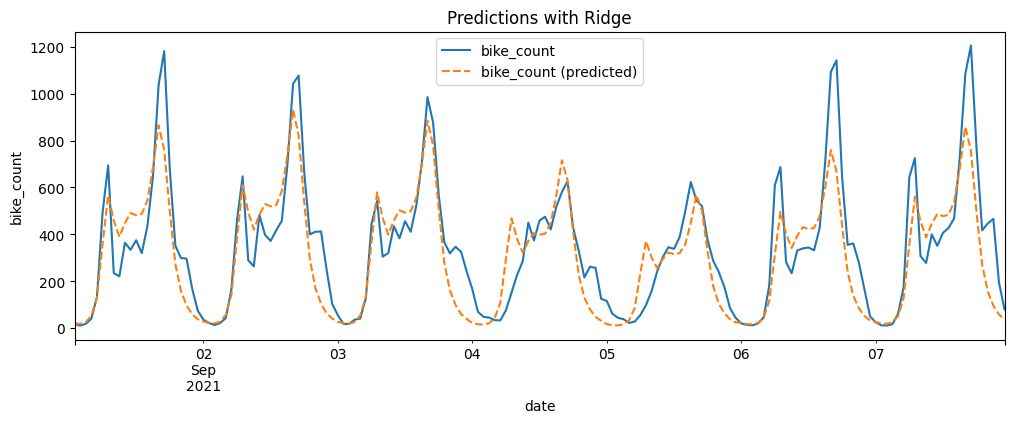

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

So we start to see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the evening are under-estimated.

A useful way to visualize the error is to plot `y_pred` as a function of `y_true`,

<Axes: xlabel='y_true', ylabel='y_pred'>

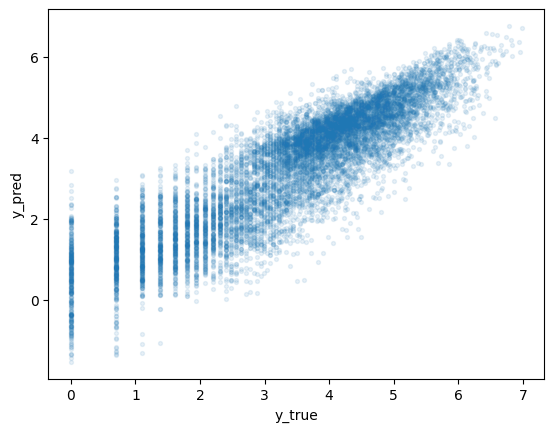

In [ ]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_valid, "y_pred": pipe.predict(X_valid)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

It is recommended to use cross-validation for hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or more reliable model evaluation with [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). In this case, because we want the test data to always be in the future as compared to the train data, we can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html):

<img src="https://i.stack.imgur.com/Q37Bn.png" />

The disadvantage, is that we can either have the training set size be different for each fold which is not ideal for hyper-parameter tuning (current figure), or have constant sized small training set which is also not ideal given the data periodicity. This explains that generally we will have worse cross-validation scores than test scores:

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.96370991 -0.87155645 -0.85104549 -0.87402962 -1.0638732  -0.96757064]
RMSE (all folds): 0.932 ± 0.0744
